In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Any, Dict, List
import warnings
import yaml

from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

In [2]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = pl.from_pandas(df)

    new_features1 = [
        (pl.col('ask_price') - pl.col('bid_price')).alias('feature1'),
        (pl.col('ask_price') - pl.col('reference_price')).alias('feature2'),
        (pl.col('bid_price') - pl.col('reference_price')).alias('feature3'),
        (pl.col('ask_price') - pl.col('wap')).alias('feature4'),
        (pl.col('bid_price') - pl.col('wap')).alias('feature5'),
        (pl.col('far_price') - pl.col('near_price')).alias('feature6'),
        (pl.col('far_price') - pl.col('reference_price')).alias('feature7'),
        (pl.col('near_price') - pl.col('reference_price')).alias('feature8'),
        (pl.col('ask_size') - pl.col('bid_size')).alias('feature9'),
        (pl.col('ask_size') - pl.col('matched_size')).alias('feature10'),
        (pl.col('bid_size') - pl.col('matched_size')).alias('feature11'),
        (pl.col('imbalance_size') - pl.col('matched_size')).alias('feature12'),
        (pl.col('ask_price') + pl.col('bid_price')).alias('feature13'),
        (pl.col('far_price') + pl.col('near_price')).alias('feature14'),
        (pl.col('ask_size') + pl.col('bid_size')).alias('feature15'),

        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('reference_price') - pl.col('bid_price'))).alias('feature16'), 
        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature17'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('bid_price') - pl.col('reference_price'))).alias('feature18'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature19'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('bid_price') - pl.col('wap'))).alias('feature20'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature21'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('reference_price') - pl.col('ask_price'))).alias('feature22'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature23'),
        ((pl.col('bid_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature24'),
        ((pl.col('bid_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature25'),
        ((pl.col('reference_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature26'),
        ((pl.col('reference_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature27'),

        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('matched_size') - pl.col('bid_size'))).alias('feature28'), 
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('bid_size') - pl.col('matched_size'))).alias('feature29'), 
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('matched_size') - pl.col('ask_size'))).alias('feature30'),

        (pl.col('bid_price') / pl.col('ask_price')).alias('feature31'),
        (pl.col('reference_price') / pl.col('ask_price')).alias('feature32'),
        (pl.col('wap') / pl.col('ask_price')).alias('feature33'),
        (pl.col('reference_price') / pl.col('bid_price')).alias('feature34'),
        (pl.col('wap') / pl.col('bid_price')).alias('feature35'),

        (pl.col('bid_size') / pl.col('ask_size')).alias('feature36'),
        (pl.col('ask_size') / pl.col('matched_size')).alias('feature37'),
        (pl.col('bid_size') / pl.col('matched_size')).alias('feature38'),
        ((pl.col('ask_price') - pl.col('bid_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature39'),
    ]

    df = (
        df
        .with_columns(new_features1)
        .to_pandas()
    )
    return df

In [3]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['row_id', 'time_id'], inplace=True)
train_df = train_df.astype(np.float32)
display(train_df)
display(train_df.describe())

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0.0,0.0,0.0,3.180603e+06,1.0,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704
1,1.0,0.0,0.0,1.666039e+05,-1.0,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986
2,2.0,0.0,0.0,3.028799e+05,-1.0,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950
3,3.0,0.0,0.0,1.191768e+07,-1.0,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201
4,4.0,0.0,0.0,4.475500e+05,-1.0,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195.0,480.0,540.0,2.440723e+06,-1.0,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276
5237976,196.0,480.0,540.0,3.495105e+05,-1.0,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077
5237977,197.0,480.0,540.0,0.000000e+00,0.0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443
5237978,198.0,480.0,540.0,1.000899e+06,1.0,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06
mean,9.928867e+01,2.415100e+02,2.699999e+02,5.715294e+06,-1.189619e-02,9.999961e-01,4.510024e+07,1.001713e+00,9.996603e-01,9.997261e-01,5.181356e+04,1.000264e+00,5.357570e+04,9.999929e-01,-4.756123e-02
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279576e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02


,target_imbalance_size_mean,target_imbalance_size_std,target_matched_size_mean,target_matched_size_std,target_bid_size_mean,target_bid_size_std,target_ask_size_mean,target_ask_size_std
count,9.523200e+04,9.523200e+04,9.523200e+04,9.523200e+04,9.523600e+04,9.523600e+04,9.523600e+04,9.523600e+04
mean,5.715293e+06,3.992132e+06,4.510024e+07,1.045875e+07,5.181359e+04,5.054482e+04,5.357568e+04,5.388874e+04
std,1.658712e+07,1.151245e+07,1.376175e+08,2.278732e+07,6.443682e+04,7.655692e+04,6.522226e+04,9.902588e+04
min,0.000000e+00,0.000000e+00,3.216563e+04,5.832037e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.238618e+05,4.711496e+05,6.058991e+06,2.150703e+06,2.015109e+04,2.097927e+04,2.108929e+04,2.157596e+04
50%,1.644225e+06,1.214866e+06,1.361294e+07,4.479579e+06,3.110650e+04,3.354866e+04,3.259076e+04,3.470452e+04
75%,4.729748e+06,3.210427e+06,3.219260e+07,9.718649e+06,5.450567e+04,5.756313e+04,5.689091e+04,5.971658e+04
max,1.432570e+09,1.172478e+09,7.192703e+09,1.780157e+09,2.800104e+06,6.304447e+06,2.621130e+06,1.001047e+07


8


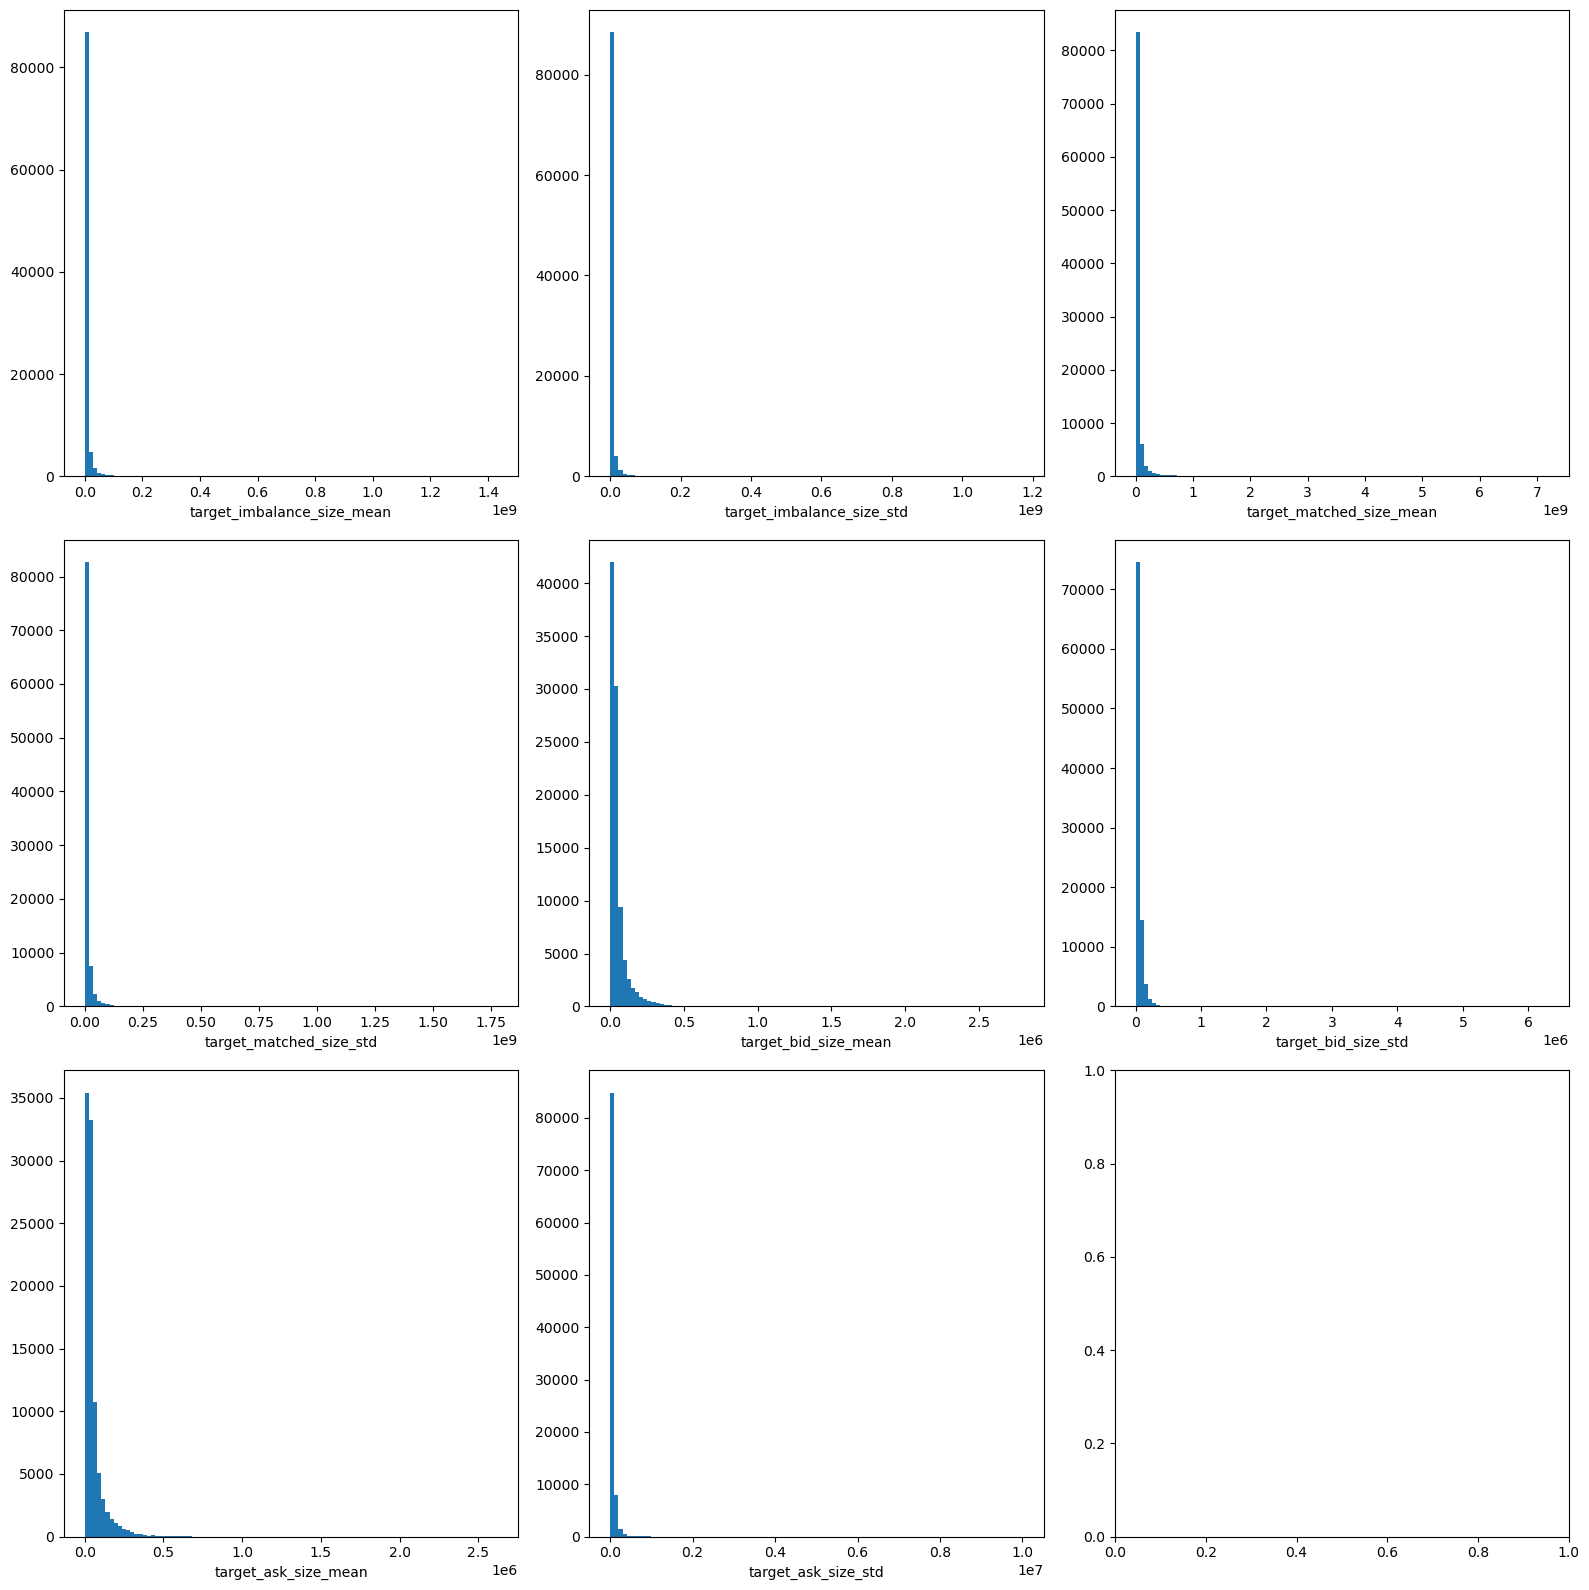

target_imbalance_size_mean  target_imbalance_size_std  \
stock_id date_id                                                          
0.0      0.0                    1.229794e+06               1.516172e+06   
         1.0                    1.175555e+06               5.772946e+05   
         2.0                    1.593084e+04               9.749596e+04   
         3.0                    5.396968e+06               1.799225e+06   
         4.0                    4.132774e+06               8.552621e+05   

                  target_matched_size_mean  target_matched_size_std  \
stock_id date_id                                                      
0.0      0.0                    20649132.0             5.655094e+06   
         1.0                     9342939.0             2.878321e+06   
         2.0                    13069748.0             2.882195e+06   
         3.0                    14145322.0             5.780270e+06   
         4.0                    18829828.0             7.863443e+06   

                  target_bid_size_mean  target_bid_size_std  \
stock_id date_id                                              
0.0      0.0              36503.148438         31260.274132   
         1.0              39277.046875         63803.089041   
         2.0              34400.523438         23986.836537   
         3.0              45016.867188         34792.442674   
         4.0              31768.835938         31265.154926   

                  target_ask_size_mean  target_ask_size_std  
stock_id date_id                                             
0.0      0.0              34108.371094         24507.687381  
         1.0              25393.017578         25219.612982  
         2.0              37903.562500         28492.340161  
         3.0              75358.914062        151637.940647  
         4.0              56905.171875         68224.874162

target_imbalance_size_mean  target_imbalance_size_std  \
stock_id date_id                                                          
0.0      0.0                       14.022358                  28.047210   
         1.0                       13.977252                  27.081619   
         2.0                        9.676075                  25.303077   
         3.0                       15.501348                  28.218377   
         4.0                       15.234460                  27.474674   

                  target_matched_size_mean  target_matched_size_std  \
stock_id date_id                                                      
0.0      0.0                     16.843184                29.363578   
         1.0                     16.050131                28.688228   
         2.0                     16.385811                28.689573   
         3.0                     16.464895                29.385471   
         4.0                     16.750954                29.693246   

                  target_bid_size_mean  target_bid_size_std  \
stock_id date_id                                              
0.0      0.0                 10.505181            24.165614   
         1.0                 10.578421            24.879067   
         2.0                 10.445856            23.900771   
         3.0                 10.714815            24.272666   
         4.0                 10.366273            24.165770   

                  target_ask_size_mean  target_ask_size_std  
stock_id date_id                                             
0.0      0.0                 10.437327            23.922253  
         1.0                 10.142269            23.950888  
         2.0                 10.542827            24.072901  
         3.0                 11.230031            25.744762  
         4.0                 10.949159            24.946075

8


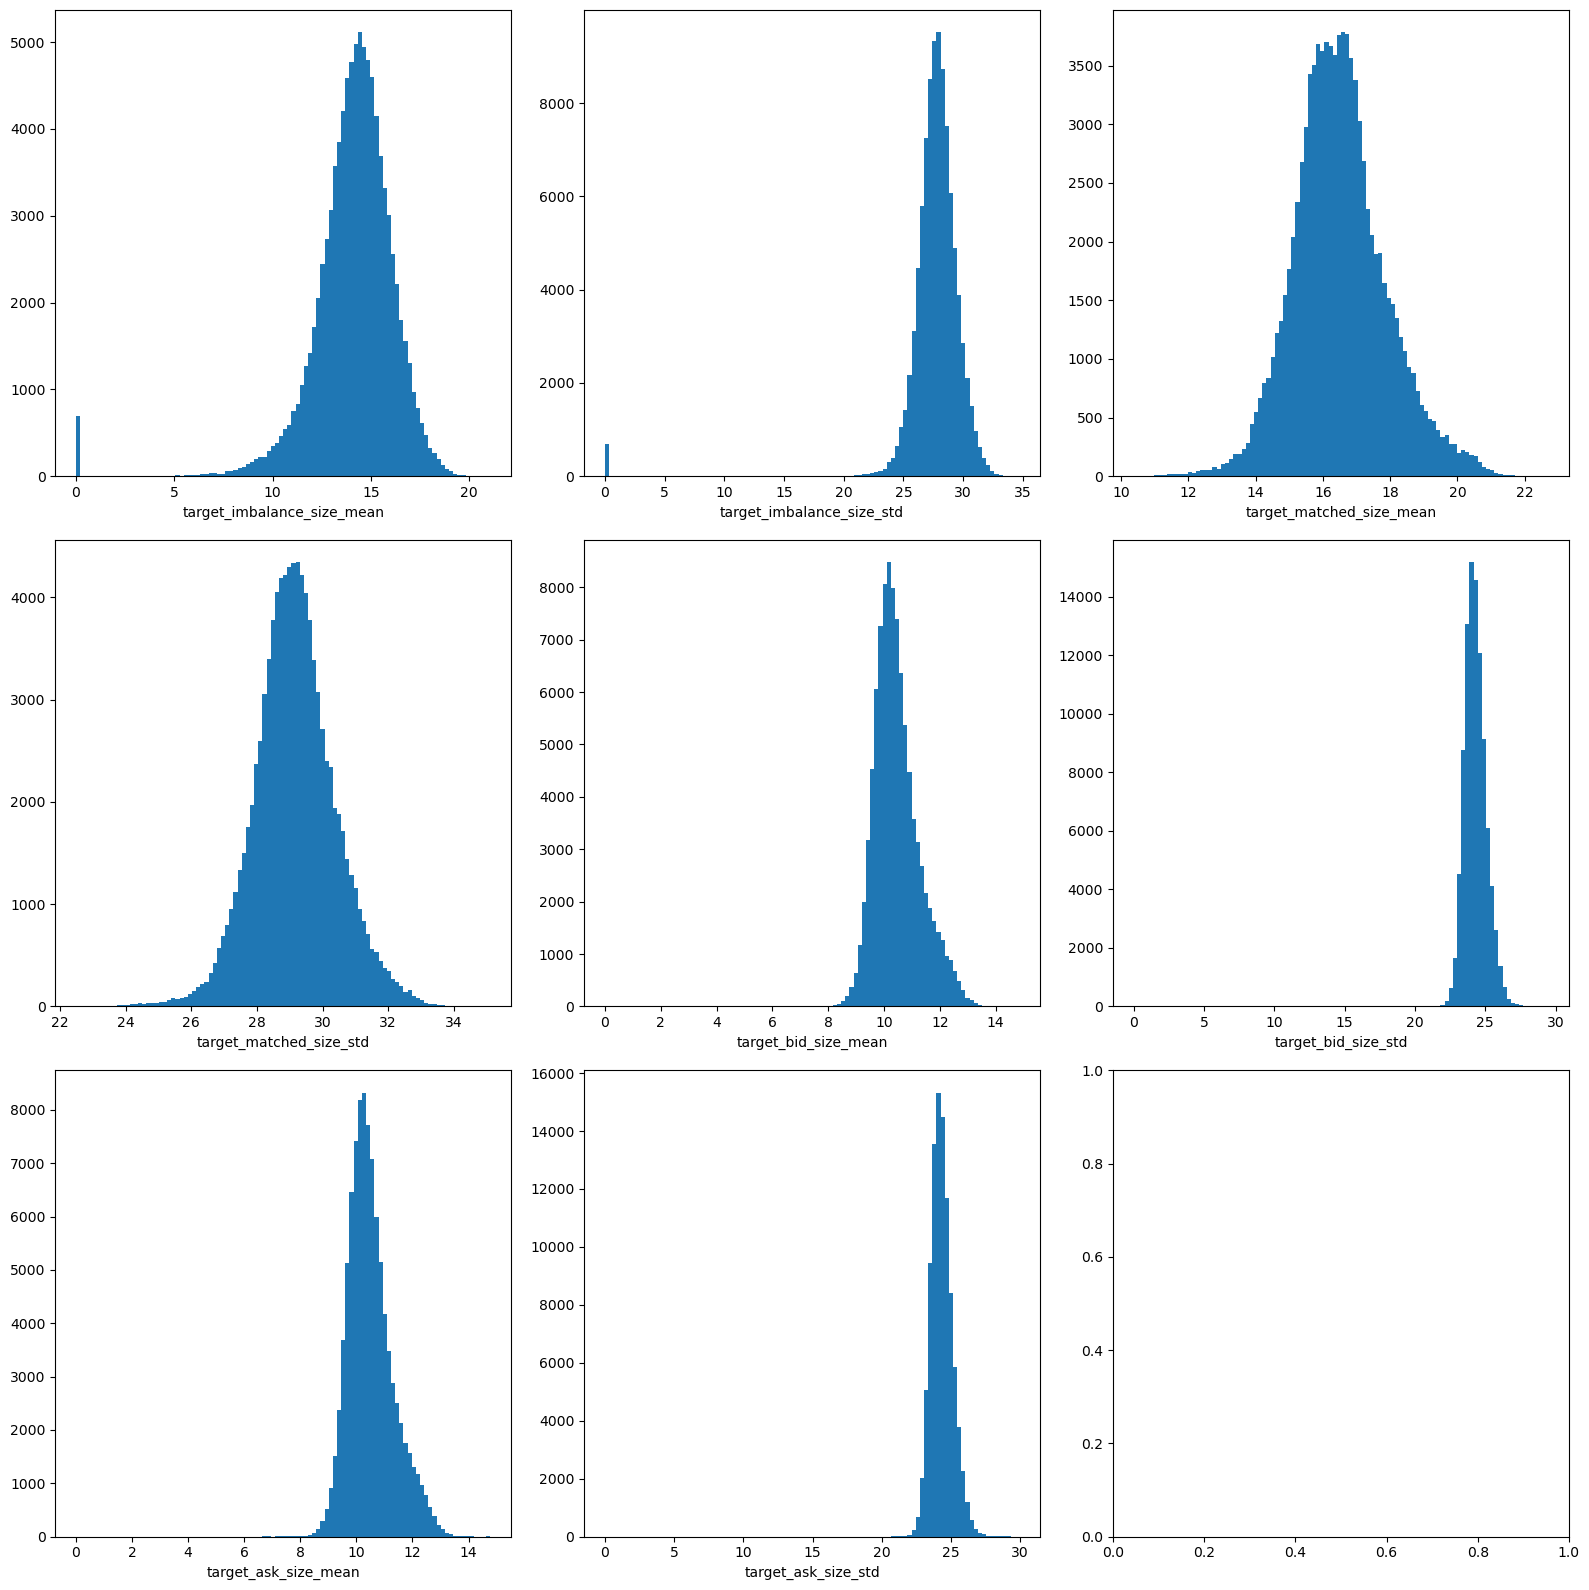

In [4]:
except_features = [
    'seconds_in_bucket',
    'imbalance_buy_sell_flag',
    'date_id',
    'stock_id',
    'target',
    'reference_price',
    'far_price',
    'near_price',
    'bid_price',
    'ask_price',
    'wap',
]

agg_features = [col for col in train_df.columns if col not in except_features]
statistics_per_date = train_df.groupby(['stock_id', 'date_id'])[agg_features].agg(['mean', 'std'])
statistics_per_date.columns = ['target_'+'_'.join(col) for col in statistics_per_date.columns]
display(statistics_per_date.describe())

target_columns = [col for col in statistics_per_date.columns if 'target' in col]
num_targets = len(target_columns)
print(num_targets)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist(statistics_per_date[target_columns[i]], bins=100)
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

display(statistics_per_date.head())
for col in statistics_per_date.columns:
    if 'mean' in col:
        statistics_per_date[col] = np.log1p(statistics_per_date[col])
    elif 'std' in col:
        statistics_per_date[col] = np.log1p(1e+06 * statistics_per_date[col])
display(statistics_per_date.head())

target_columns = [col for col in statistics_per_date.columns if 'target' in col]
num_targets = len(target_columns)
print(num_targets)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist(statistics_per_date[target_columns[i]], bins=100)
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

In [5]:
train_df = preprocess(train_df)
train_df = train_df.groupby(['stock_id', 'date_id']).first().drop(columns=['target', 'seconds_in_bucket'])

train_df = train_df.merge(statistics_per_date, on=['stock_id', 'date_id']).reset_index()
train_df.dropna(inplace=True)
display(train_df)

del statistics_per_date
gc.collect()

,stock_id,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,target_imbalance_size_mean,target_imbalance_size_std,target_matched_size_mean,target_matched_size_std,target_bid_size_mean,target_bid_size_std,target_ask_size_mean,target_ask_size_std
0,0.0,0.0,3180602.750,1.0,0.999812,13380277.0,1.000241,1.000241,0.999812,60651.500000,1.000026,8493.030273,1.0,0.000214,0.000214,0.000000,0.000026,-0.000188,0.000000,0.000000,0.000000,-52158.468750,-13371784.0,-13319626.0,-10199674.00,1.999838,2.000482,69144.531250,inf,1.138237,inf,1.138237,-0.138237,-0.138237,1.000000,8.233945,0.000000,1.000000,8.233945,0.000000,-0.003916,1.003916,0.003901,0.999786,0.999786,0.999974,1.000000,1.000188,7.141326,0.000635,0.004533,-0.000161,14.022358,28.047210,16.843184,29.363578,10.505181,24.165614,10.437327,23.922253
1,0.0,1.0,1870169.375,1.0,0.999923,5132566.5,1.018514,1.010132,0.999601,9302.000000,1.000998,23287.500000,1.0,0.001397,0.001075,-0.000322,0.000998,-0.000399,0.008382,0.018913,0.010531,13985.500000,-5109279.0,-5123264.5,-3262397.00,2.000599,2.028646,32589.500000,4.338763,3.501344,-3.338763,13.959752,-2.501344,-12.959752,1.299512,1.399785,-4.181115,5.181115,1.077162,0.806991,0.002730,0.997270,-0.002737,0.998604,0.998926,0.999003,1.000322,1.000399,0.399442,0.004537,0.001812,0.000600,13.977252,27.081619,16.050131,28.688228,10.578421,24.879067,10.142269,23.950888
2,0.0,2.0,0.000,0.0,0.999968,9704431.0,0.998774,0.998774,0.999968,4055.479980,1.000185,23231.880859,1.0,0.000217,0.000217,0.000000,0.000185,-0.000032,0.000000,0.000000,0.000000,19176.400391,-9681199.0,-9700376.0,-9704431.00,2.000153,1.997548,27287.361328,inf,6.780261,inf,6.780261,-5.780261,-5.780261,1.000000,1.173003,0.000000,1.000000,1.173003,0.000000,0.001977,0.998023,-0.001981,0.999783,0.999783,0.999815,1.000000,1.000032,0.174565,0.002394,0.000418,0.000153,9.676075,25.303077,16.385811,28.689573,10.445856,23.900771,10.542827,24.072901
3,0.0,3.0,3993793.750,-1.0,1.000232,8122459.5,0.908138,0.908138,0.999907,9218.000000,1.000341,33752.519531,1.0,0.000434,0.000109,-0.000325,0.000341,-0.000093,-0.050983,-0.089708,-0.090684,24534.519531,-8088707.0,-8113241.5,-4128665.75,2.000248,1.867259,42970.519531,1.335657,4.667949,-0.335657,-0.470195,-3.667949,1.470195,3.979235,1.272632,1.400822,-0.400822,0.319818,3.494872,0.003024,0.996976,-0.003033,0.999566,0.999891,0.999659,1.000325,1.000093,0.273106,0.004155,0.001135,0.000248,15.501348,28.218377,16.464895,29.385471,10.714815,24.272666,11.230031,25.744762
4,0.0,4.0,4529594.000,-1.0,1.000232,10151651.0,0.980448,0.980551,0.999923,46870.320312,1.000335,204062.156250,1.0,0.000412,0.000103,-0.000309,0.000335,-0.000077,-0.000103,-0.019887,-0.019784,157191.843750,-9947589.0,-10104781.0,-5622057.00,2.000258,1.960999,250932.468750,1.333333,5.349845,-0.333333,-0.443988,-4.349845,1.443988,4.000000,1.229893,1.331963,-0.331963,0.307473,4.012384,0.015556,0.984444,-0.015802,0.999588,0.999897,0.999665,1.000309,1.000077,0.229686,0.020101,0.004617,0.000258,15.234460,27.474674,16.750954,29.693246,10.366273,24.165770,10.949159,24.946075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95231,199.0,476.0,1368594.500,1.0,1.000091,12793905.0,1.050790,1.017206,0.999768,77338.078125,1.000091,30381.570312,1.0,0.000323,0.000000,-0.000323,0.000091,-0.000232,0.033584,0.049084,0.015500,-46956.507812,-12763523.0,-12716567.0,-11425

30

## train catboost models using cross validation

In [6]:
def train(
        dataset: pd.DataFrame,
        model_params: Dict[str, Any],
        outputs_dir: pathlib.Path,
    ):
    
    target_columns = [col for col in dataset.columns if 'target' in col]
    print(target_columns)
    feature_columns = [col for col in dataset.columns if col not in target_columns and col != 'date_id']
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    result_pred = np.zeros((11990, 8))
    result_true = np.zeros((11990, 8))

    history = {
        'train_mae': [],
        'valid_mae': [],
    }

    mean_num_iteration = 0

    step = 60
    valid_days = days[-step:]
    valid_X = dataset.query('date_id in @valid_days')[feature_columns]
    valid_y = dataset.query('date_id in @valid_days')[target_columns]

    train_day_lower_limits = np.arange(0, 480-step, step)

    for k, lower_limit in enumerate(train_day_lower_limits):
        train_days = np.arange(lower_limit, lower_limit+step)
        print(f'fold {k+1}')
        print(train_days)
        print(valid_days)
        
        plot_time(days, train_days, valid_days)
        
        train_X = dataset.query('date_id in @train_days')[feature_columns]
        train_y = dataset.query('date_id in @train_days')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        
        train_pool = Pool(data=train_X, label=train_y)
        valid_pool = Pool(data=valid_X, label=valid_y)
        
        model = CatBoostRegressor(**model_params)
        model.fit(
            X=train_pool,
            eval_set=[(valid_pool)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=500,
        )
        model.save_model(
            outputs_dir.joinpath(f'catboost_fold{k+1}_predict_size_statistics.txt'),
        )
        
        fimp = model.get_feature_importance(valid_pool, type='PredictionValuesChange')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)

        train_pred = model.predict(train_X)
        valid_pred = model.predict(valid_X)
        
        result_pred += valid_pred
        result_true += valid_y.values

        history['train_mae'].append(np.mean(abs(train_y.values - train_pred), axis=0))
        history['valid_mae'].append(np.mean(abs(valid_y.values - valid_pred), axis=0))

        mean_num_iteration += model.get_best_iteration()

        del train_X, train_y, train_pool, valid_pool, model, fimp
        del train_pred, valid_pred
        gc.collect()

    del valid_X, valid_y
    gc.collect()

    history = pd.DataFrame.from_dict(history)
    mean_num_iteration = int(mean_num_iteration / len(train_day_lower_limits))

    result_pred /= len(train_day_lower_limits)
    result_true /= len(train_day_lower_limits)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    fimps.index = [f'{len(fimps)-i}_{idx}' for i, idx in enumerate(fimps.index)]
    
    return history, result_pred, result_true, fimps, mean_num_iteration


def plot_time(all_time, train_time, valid_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid+test', height=0.6, width=[len(train_time), len(valid_time)],
            left=[train_time.min(), valid_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [f'all\n{len(all_time)}', f'train\n{len(train_time)}', f'valid\n{len(valid_time)}']
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), train_time.max(), valid_time.min(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

['target_imbalance_size_mean', 'target_imbalance_size_std', 'target_matched_size_mean', 'target_matched_size_std', 'target_bid_size_mean', 'target_bid_size_std', 'target_ask_size_mean', 'target_ask_size_std']
fold 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 445. 446. 447.
 448. 449. 450. 451. 452. 453. 454. 455. 456. 457. 458. 459. 460. 461.
 462. 463. 464. 465. 466. 467. 468. 469. 470. 471. 472. 473. 474. 475.
 476. 477. 478. 479.]


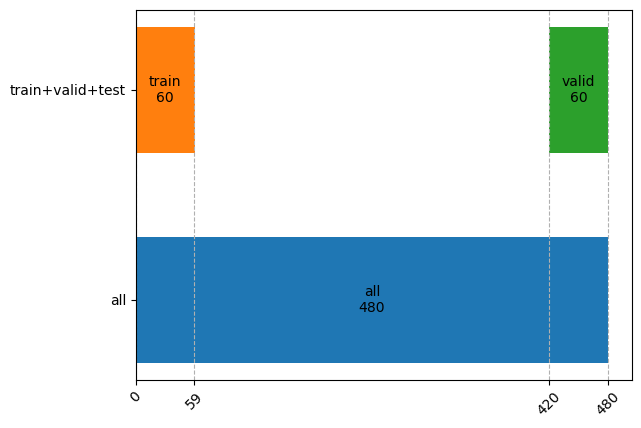

train_X.shape: (11561, 51), train_y.shape: (11561, 8)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 8)
0:	learn: 4.9333033	test: 3.7921339	best: 3.7921339 (0)	total: 181ms	remaining: 15m 5s
500:	learn: 2.9735300	test: 2.1915124	best: 2.1915124 (500)	total: 1m 6s	remaining: 9m 54s
1000:	learn: 2.5940363	test: 2.1565501	best: 2.1562306 (956)	total: 2m 11s	remaining: 8m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.156230595
bestIteration = 956

Shrink model to first 957 iterations.
fold 2
[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 445. 446. 447.
 448. 449. 450. 451. 452. 453. 454. 455. 456. 457. 458. 459. 460. 461.
 462. 463. 464. 46

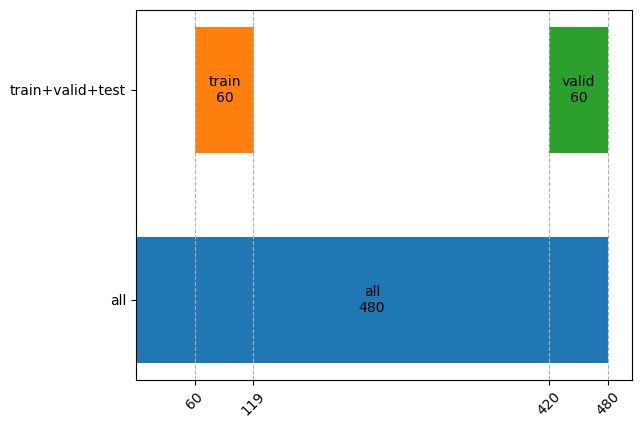

train_X.shape: (11779, 51), train_y.shape: (11779, 8)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 8)
0:	learn: 4.3750983	test: 3.6956369	best: 3.6956369 (0)	total: 126ms	remaining: 10m 27s
500:	learn: 2.4954432	test: 2.1586138	best: 2.1586138 (500)	total: 1m 6s	remaining: 9m 53s
1000:	learn: 2.1322903	test: 2.1213675	best: 2.1213675 (1000)	total: 2m 11s	remaining: 8m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.119740912
bestIteration = 1192

Shrink model to first 1193 iterations.
fold 3
[120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 445. 446. 447.
 448. 449. 450. 451. 452. 453. 454. 455. 456. 457. 458. 459. 460. 461.
 462. 463. 464

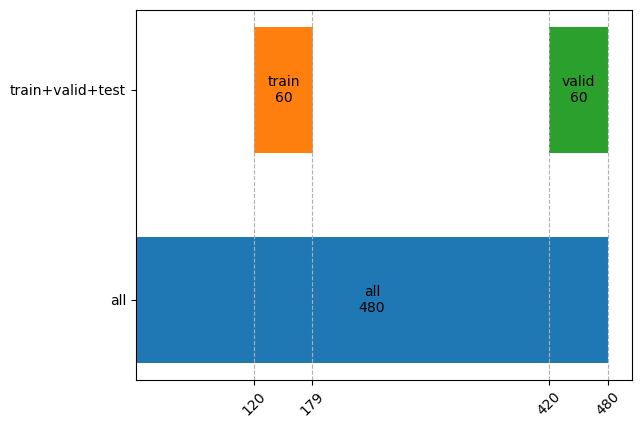

train_X.shape: (11818, 51), train_y.shape: (11818, 8)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 8)
0:	learn: 4.6213147	test: 3.7313791	best: 3.7313791 (0)	total: 124ms	remaining: 10m 21s
500:	learn: 2.5873438	test: 2.1700309	best: 2.1700309 (500)	total: 1m 6s	remaining: 9m 53s
1000:	learn: 2.1991839	test: 2.1406669	best: 2.1406578 (981)	total: 2m 11s	remaining: 8m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.140490428
bestIteration = 1009

Shrink model to first 1010 iterations.
fold 4
[180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 445. 446. 447.
 448. 449. 450. 451. 452. 453. 454. 455. 456. 457. 458. 459. 460. 461.
 462. 463. 464.

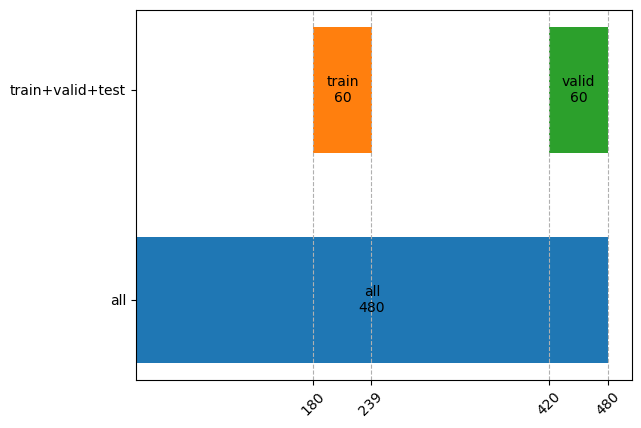

train_X.shape: (11925, 51), train_y.shape: (11925, 8)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 8)
0:	learn: 4.6880605	test: 3.7711476	best: 3.7711476 (0)	total: 126ms	remaining: 10m 31s
500:	learn: 2.7256376	test: 2.1579328	best: 2.1579328 (500)	total: 1m 6s	remaining: 9m 55s
1000:	learn: 2.3237205	test: 2.1229228	best: 2.1221485 (900)	total: 2m 12s	remaining: 8m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.12214847
bestIteration = 900

Shrink model to first 901 iterations.
fold 5
[240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 445. 446. 447.
 448. 449. 450. 451. 452. 453. 454. 455. 456. 457. 458. 459. 460. 461.
 462. 463. 464. 46

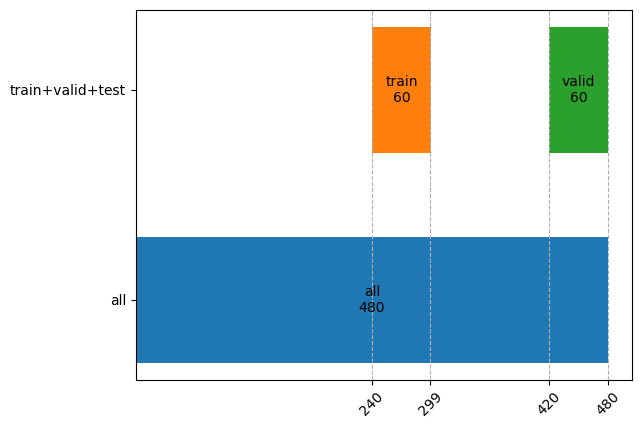

train_X.shape: (11944, 51), train_y.shape: (11944, 8)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 8)
0:	learn: 4.2781324	test: 3.7466404	best: 3.7466404 (0)	total: 123ms	remaining: 10m 15s
500:	learn: 2.3731771	test: 2.1171230	best: 2.1171230 (500)	total: 1m 6s	remaining: 9m 54s
1000:	learn: 2.0422400	test: 2.0541522	best: 2.0541522 (1000)	total: 2m 11s	remaining: 8m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.052308796
bestIteration = 1261

Shrink model to first 1262 iterations.
fold 6
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354 355 356 357 358 359]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 445. 446. 447.
 448. 449. 450. 451. 452. 453. 454. 455. 456. 457. 458. 459. 460. 461.
 462. 463. 464

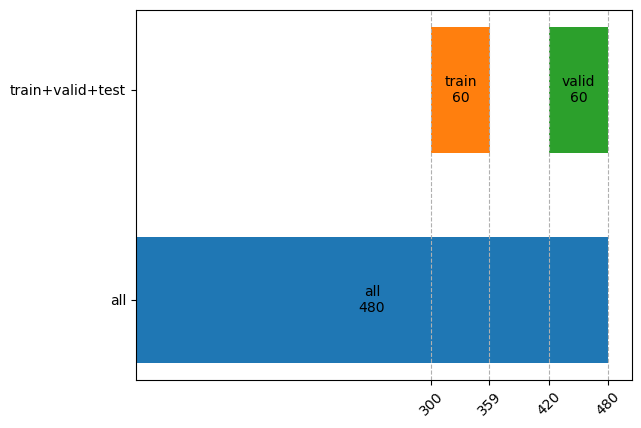

train_X.shape: (11997, 51), train_y.shape: (11997, 8)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 8)
0:	learn: 3.8348448	test: 3.7099767	best: 3.7099767 (0)	total: 131ms	remaining: 10m 53s
500:	learn: 1.9205333	test: 2.1055633	best: 2.1055633 (500)	total: 1m 5s	remaining: 9m 52s
1000:	learn: 1.6254632	test: 2.0244003	best: 2.0243861 (998)	total: 2m 11s	remaining: 8m 45s
1500:	learn: 1.4441431	test: 2.0093378	best: 2.0093378 (1500)	total: 3m 17s	remaining: 7m 39s
2000:	learn: 1.3016236	test: 2.0022428	best: 2.0021330 (1998)	total: 4m 22s	remaining: 6m 33s
2500:	learn: 1.1882575	test: 1.9944434	best: 1.9944434 (2500)	total: 5m 28s	remaining: 5m 28s
3000:	learn: 1.0932195	test: 1.9897535	best: 1.9897202 (2995)	total: 6m 34s	remaining: 4m 22s
3500:	learn: 1.0131256	test: 1.9866205	best: 1.9866205 (3500)	total: 7m 39s	remaining: 3m 16s
4000:	learn: 0.9436427	test: 1.9839199	best: 1.9839199 (4000)	total: 8m 46s	remaining: 2m 11s
Stopped by overfitting detector  (100 iterations wait)



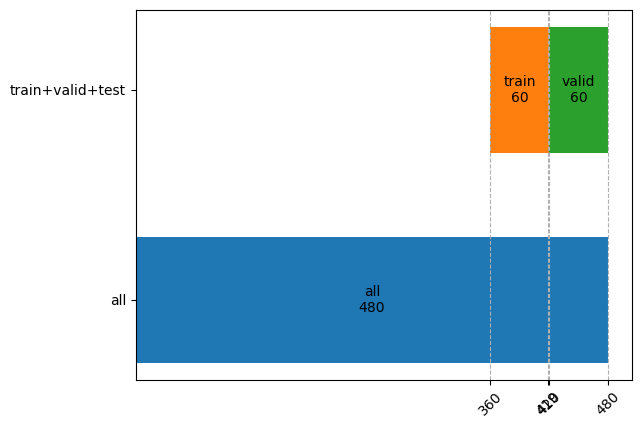

train_X.shape: (11998, 51), train_y.shape: (11998, 8)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 8)
0:	learn: 3.5869498	test: 3.6891480	best: 3.6891480 (0)	total: 127ms	remaining: 10m 35s
500:	learn: 1.8227794	test: 2.0928813	best: 2.0928813 (500)	total: 1m 6s	remaining: 9m 58s
1000:	learn: 1.5567012	test: 1.9872836	best: 1.9872836 (1000)	total: 2m 12s	remaining: 8m 50s
1500:	learn: 1.4035599	test: 1.9598635	best: 1.9598635 (1500)	total: 3m 18s	remaining: 7m 43s
2000:	learn: 1.2812852	test: 1.9480547	best: 1.9480547 (2000)	total: 4m 24s	remaining: 6m 37s
2500:	learn: 1.1811678	test: 1.9365032	best: 1.9365032 (2500)	total: 5m 30s	remaining: 5m 30s
3000:	learn: 1.0936992	test: 1.9289723	best: 1.9289723 (3000)	total: 6m 36s	remaining: 4m 24s
3500:	learn: 1.0172721	test: 1.9240564	best: 1.9240470 (3496)	total: 7m 42s	remaining: 3m 17s
4000:	learn: 0.9490021	test: 1.9211696	best: 1.9211696 (4000)	total: 8m 48s	remaining: 2m 11s
4500:	learn: 0.8862394	test: 1.9191338	best: 1.9191125 

In [7]:
params = {
    'loss_function': 'MultiRMSE',
    'eval_metric': 'MultiRMSE',
    'iterations': 5000,
    'depth': 10,
    'learning_rate': 5e-03,
    'random_state': 42,
    'bagging_temperature': 0.8,
    'random_strength': 0.8,
    #'subsample': 0.8,
    'colsample_bylevel': 0.8,
    'l2_leaf_reg': 0.0,
    'min_data_in_leaf': 20,
}

history, result_pred, result_true, fimps, mean_num_iteration = train(
    dataset=train_df,
    model_params=params,
    outputs_dir=outputs_dir_path,
)

array([[15.01494219, 28.305864  , 17.08749869, ..., 24.31176072,
        10.65456441, 24.50111597],
       [15.88926006, 29.09141706, 16.87428253, ..., 24.42920846,
        10.30287974, 24.2133479 ],
       [13.8583674 , 27.56003647, 16.62919903, ..., 24.22264134,
        10.7806078 , 24.49298762],
       ...,
       [14.90270583, 28.04193904, 16.41247917, ..., 24.35742677,
        10.99599845, 24.68017961],
       [14.09334088, 27.41029054, 16.04234409, ..., 24.65298459,
        10.85626706, 24.46607751],
       [14.53529286, 27.99907124, 17.03528091, ..., 24.62274717,
        10.63021786, 24.34144041]])

array([[14.65931129, 27.95919388, 17.19391823, ..., 23.69266828,
        10.6440649 , 24.38066897],
       [15.78704643, 28.83078171, 16.96994019, ..., 24.45059425,
        10.98381233, 24.84117615],
       [14.24896336, 27.53375489, 16.64053917, ..., 23.97001098,
        10.66726112, 24.11892966],
       ...,
       [15.15768433, 28.09593927, 16.40916443, ..., 24.63266862,
        11.04502392, 24.53974386],
       [13.90631771, 27.53041876, 16.19542503, ..., 24.72543205,
        11.11735153, 24.74303467],
       [14.66718483, 28.59134821, 17.13814163, ..., 24.65848916,
        10.83707809, 24.41170986]])

(51, 9)


,fold1,fold2,fold3,fold4,fold5,fold6,fold7,mean_fimps,std_fimps
50_feature17,0.355715,0.252093,0.305734,0.427093,0.362049,0.404969,0.418017,0.360810,0.063896
49_feature20,0.419918,0.271089,0.347239,0.343046,0.390874,0.537101,0.425242,0.390644,0.083613
48_feature36,0.360534,0.281229,0.383469,0.438110,0.453417,0.472460,0.565685,0.422129,0.090846
47_feature23,0.464059,0.338472,0.338125,0.518352,0.357941,0.469319,0.481116,0.423912,0.076241
46_feature13,0.494627,0.324735,0.395172,0.456421,0.626308,0.595403,0.547462,0.491447,0.108344
45_feature19,0.643792,0.641233,0.323278,0.487083,0.390914,0.433836,0.568619,0.498394,0.124491
44_feature25,0.514914,0.726707,0.256224,0.464179,0.387483,0.412439,0.758576,0.502932,0.182326
43_feature39,0.624954,0.500324,0.479479,0.492733,0.505530,0.512657,0.503357,0.517005,0.048760
42_feature27,0.292685,0.397988,0.565498,0.564264,0.604470,0.702674,0.707255,0.547834,0.153153
41_feature21,0.675490,0.696529,0.379676,0.524832,0.481979,0.467406,0.620492,0.549486,0.117812


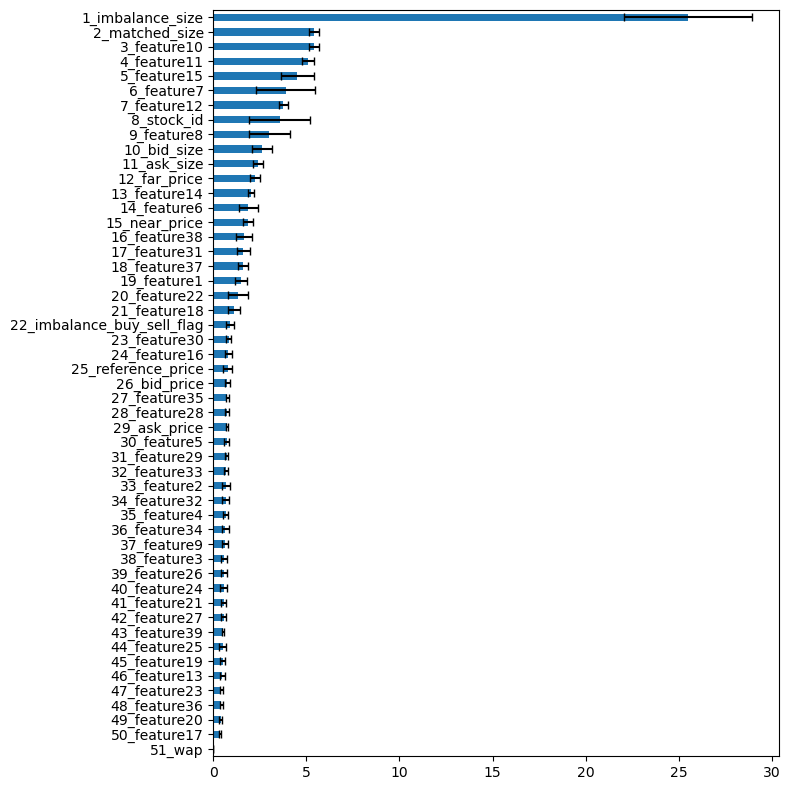

Index(['51_wap', '50_feature17', '49_feature20', '48_feature36',
       '47_feature23', '46_feature13', '45_feature19', '44_feature25',
       '43_feature39', '42_feature27'],
      dtype='object')

In [8]:
display(result_pred)
display(result_true)
print(fimps.shape)
display(fimps.tail(50))

_, ax = plt.subplots(figsize=(8, 8))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)  
plt.tight_layout()
plt.show()

fimps_quantile_th = fimps['mean_fimps'].quantile(q=0.2)
display(fimps.query('mean_fimps < @fimps_quantile_th').index)

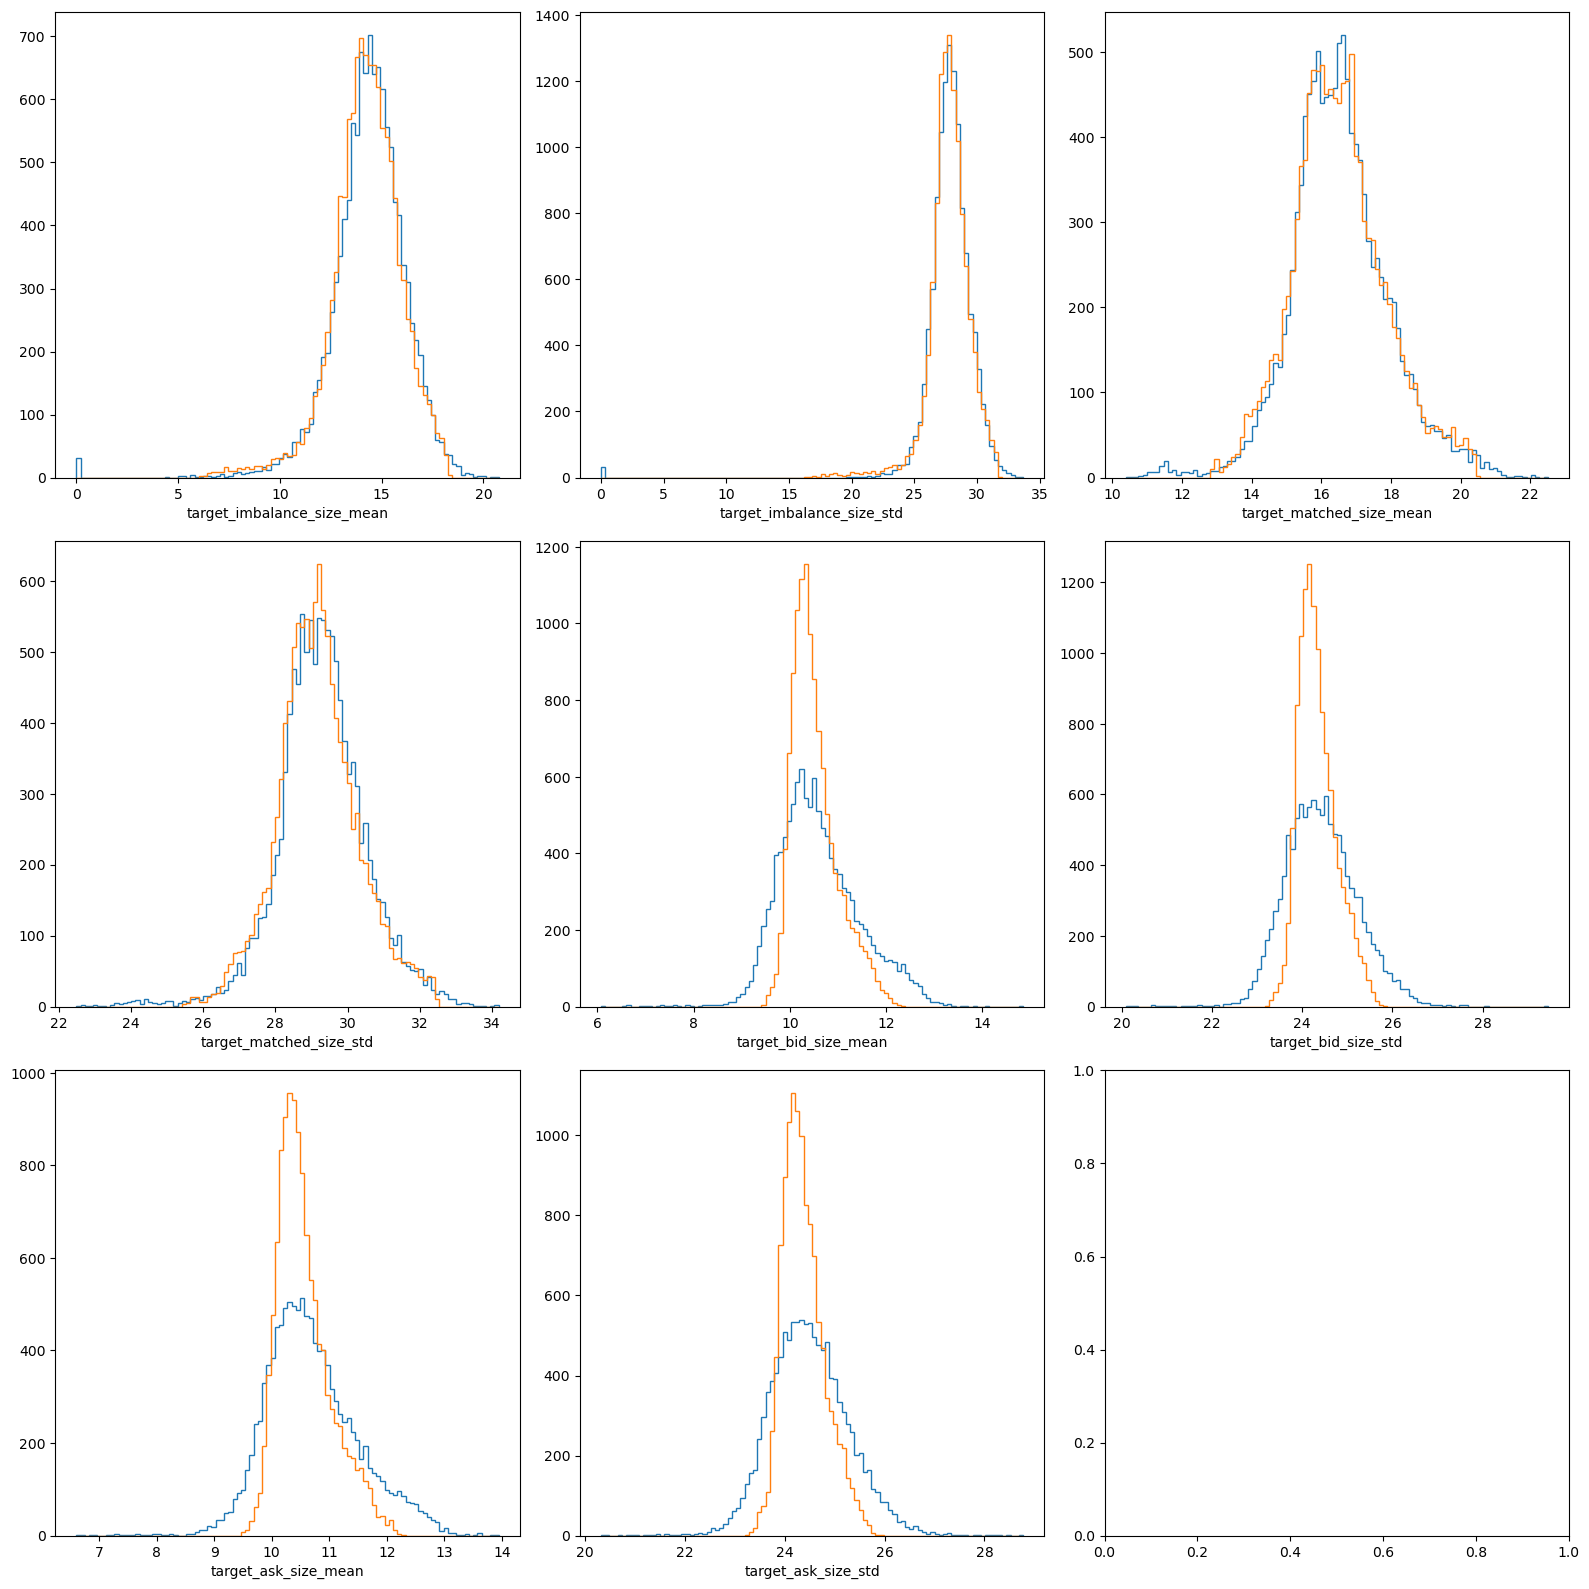

In [9]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    _, bins, _ = axs[i//3, i%3].hist(result_true[:, i], bins=100, histtype='step')
    axs[i//3, i%3].hist(result_pred[:, i], bins=bins, histtype='step')
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

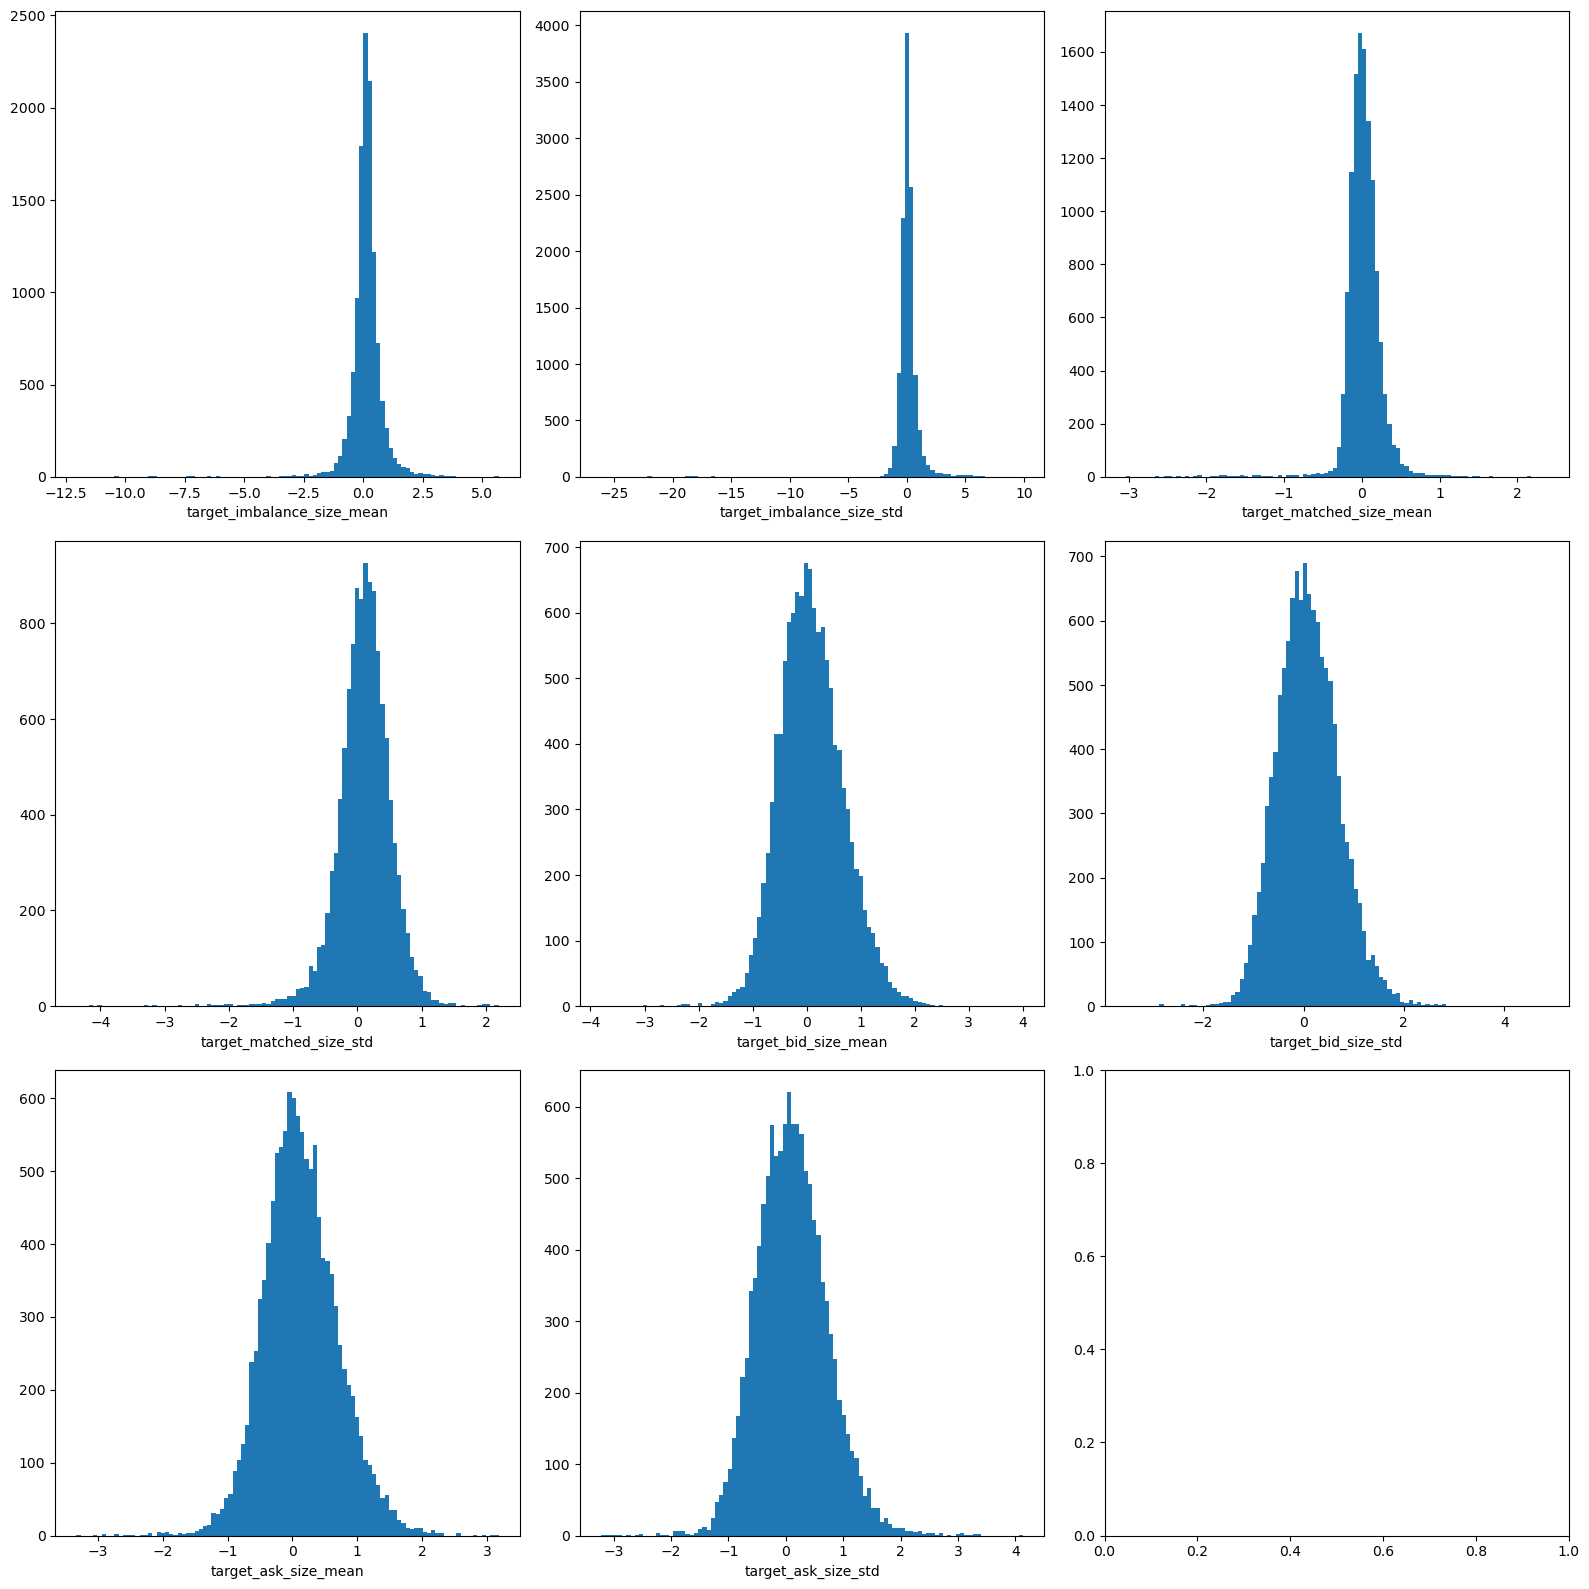

In [10]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist(result_true[:, i]-result_pred[:, i], bins=100)
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

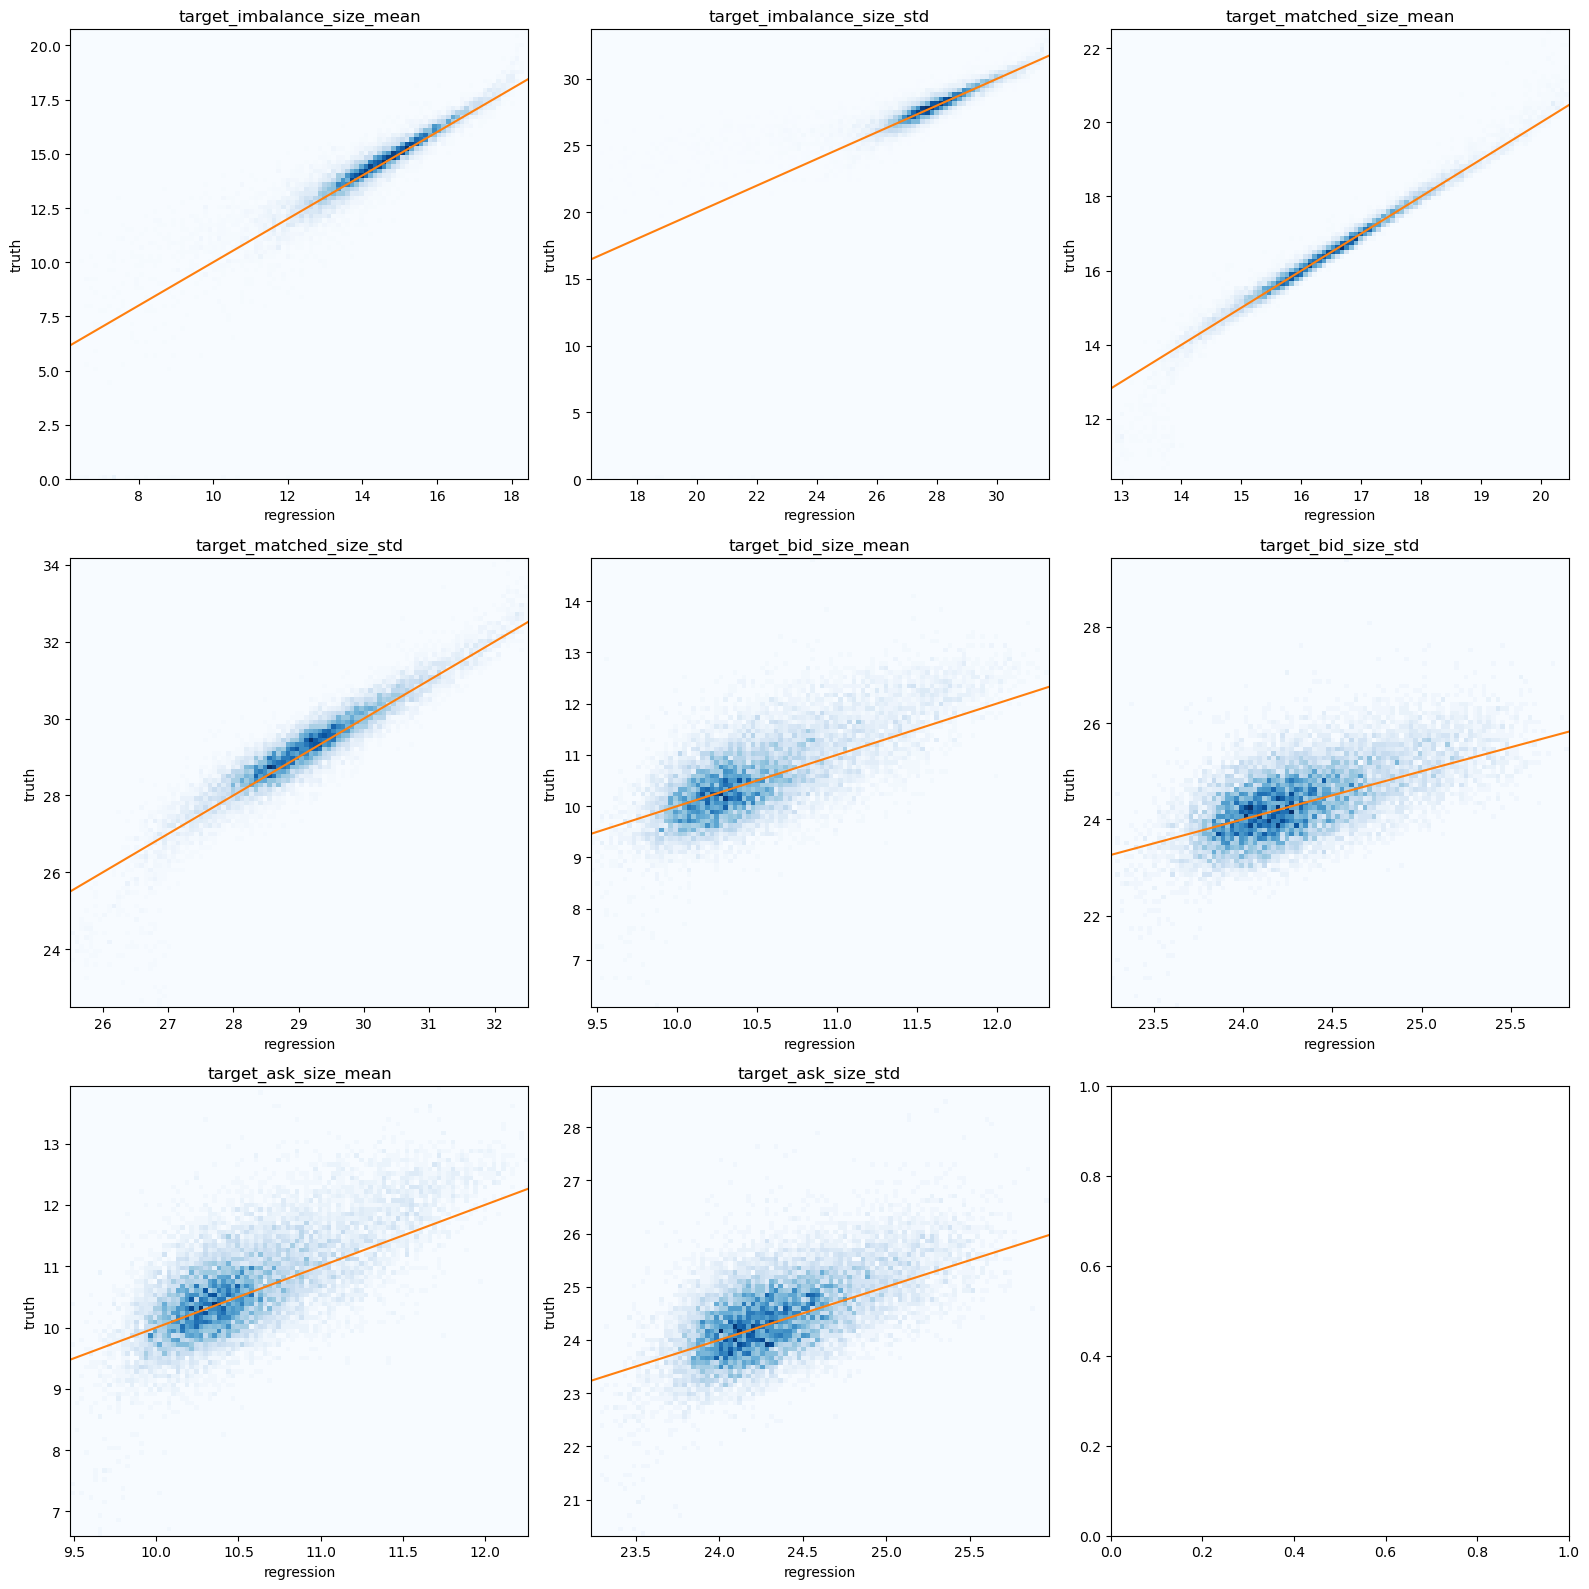

In [11]:
arget_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist2d(result_pred[:, i], result_true[:, i], bins=100, cmap='Blues')
    axs[i//3, i%3].plot([-100, 100], [-100, 100], color='tab:orange')
    axs[i//3, i%3].set_xlabel('regression')
    axs[i//3, i%3].set_ylabel('truth')
    axs[i//3, i%3].set_title(target_columns[i])
plt.tight_layout()
plt.show()

In [12]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)

for i in range(num_targets):
   r = np.corrcoef(result_true[:, i], result_pred[:, i])
   print(f'{target_columns[i]}: {r[0, 1]:.4f}')

target_imbalance_size_mean: 0.9190
target_imbalance_size_std: 0.7772
target_matched_size_mean: 0.9837
target_matched_size_std: 0.9382
target_bid_size_mean: 0.7122
target_bid_size_std: 0.6157
target_ask_size_mean: 0.7083
target_ask_size_std: 0.6157


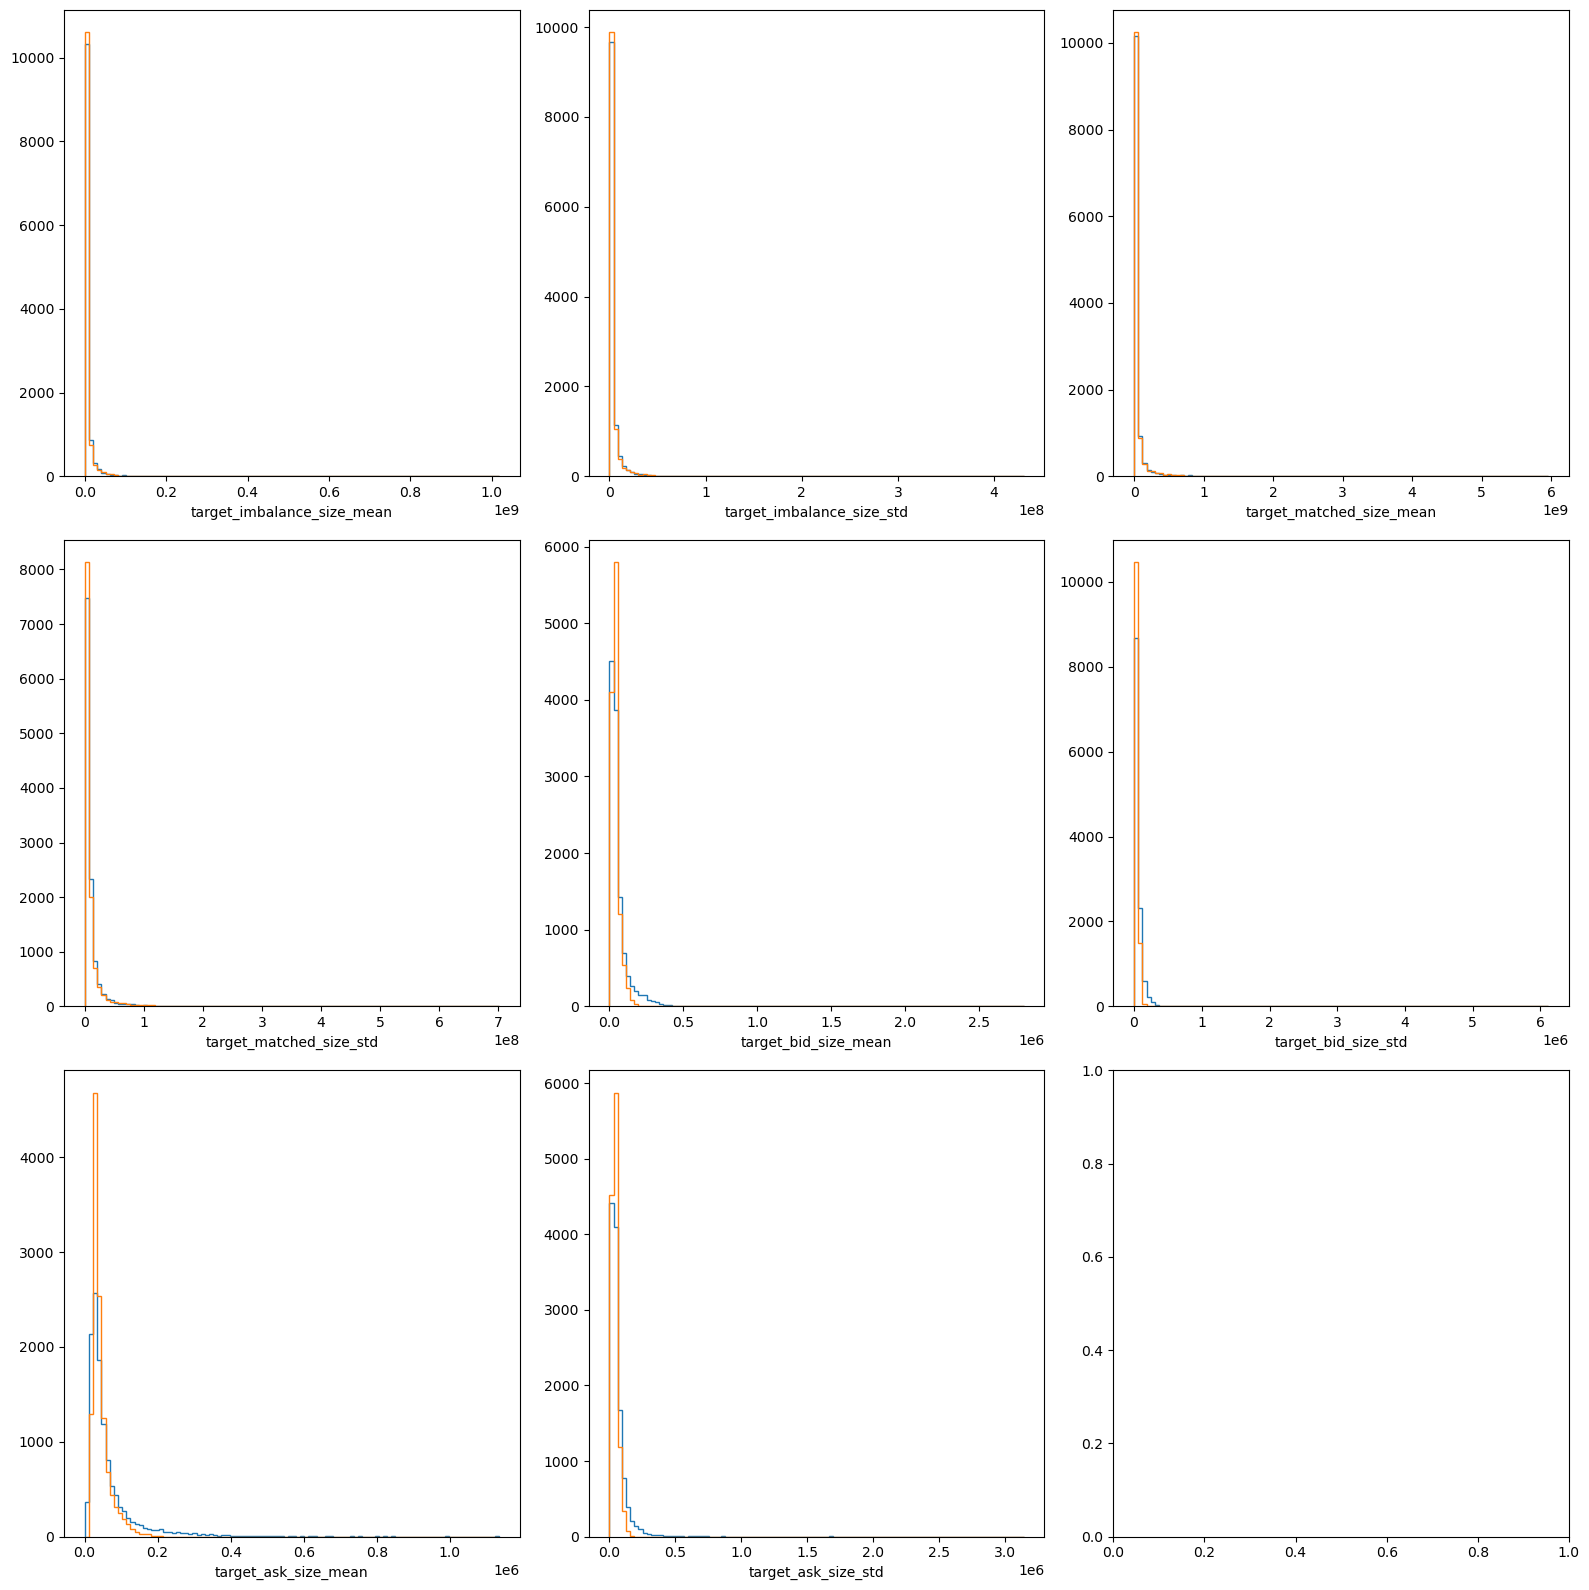

In [13]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    true = np.exp(result_true[:, i]) - 1
    reg = np.exp(result_pred[:, i]) - 1
    if 'std' in target_columns[i]:
        true /= 1e+06
        reg /= 1e+06
    _, bins, _ = axs[i//3, i%3].hist(true, bins=100, histtype='step')
    axs[i//3, i%3].hist(reg, bins=bins, histtype='step')
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

## train catboost model using all data

In [14]:
target_columns = [col for col in train_df.columns if 'target' in col]
print(target_columns)
feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'date_id']


train_pool = Pool(
    data=train_df[feature_columns],
    label=train_df[target_columns],
)

del train_df
gc.collect()

params['iterations'] = mean_num_iteration

model = CatBoostRegressor(**params)
model.fit(
    X=train_pool,
    use_best_model=True,
    verbose=500,
)
model.save_model(
    outputs_dir_path.joinpath(f'catboost_trained_using_alldata_predict_size_statistics.txt'),
)

['target_imbalance_size_mean', 'target_imbalance_size_std', 'target_matched_size_mean', 'target_matched_size_std', 'target_bid_size_mean', 'target_bid_size_std', 'target_ask_size_mean', 'target_ask_size_std']


You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 4.2840209	total: 152ms	remaining: 5m 14s
500:	learn: 2.5766639	total: 1m 20s	remaining: 4m 10s
1000:	learn: 2.4636067	total: 2m 39s	remaining: 2m 49s
1500:	learn: 2.3971251	total: 3m 57s	remaining: 1m 29s
2000:	learn: 2.3329164	total: 5m 16s	remaining: 10.6s
2067:	learn: 2.3235895	total: 5m 27s	remaining: 0us
